##Libraries

In [2]:
#Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import PIL
import random
# import cv2
from PIL import Image

#Torch
import torch
import torchvision
from torchvision import utils
from torchvision import models
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

##Create dataset

In [3]:
#Make dict with all images path & label & image array
base_folder = ''
motos_cathegory = []
for moto in os.listdir(base_folder):
    motos_cathegory.append(moto)
# motos_cathegory.pop()

all_imgs = []
for moto in motos_cathegory:
    # print(moto)
    type_moto_folder = base_folder + '/' + moto
    for i, img in enumerate(os.listdir(type_moto_folder)):
        path = type_moto_folder + '/' + img
        img_dict = {}
        img_dict['path'] = path 
        img_dict['cath'] = moto
        for m in motos_cathegory:
            img_dict[m] = 0
            if m == moto:
                img_dict[m] = 1
        all_imgs.append(img_dict)

#Labels
print(motos_cathegory)
# all_imgs lenght
print(len(all_imgs))

# This piece of code return a dict named all_imgs with this structure:
    
#     {'path':'IMAGE_PATH',
#     'cath' : 'MOTO_CATHEGORY',
#     'off_road': *, 
#     'naked': *, 
#     'scooter': *, 
#     'scrambler': *, 
#     'cafe_racer': *, 
#     'cruiser': *, 
#     'sport': *, 
#     'touring': *, 
#     'bike': *, 
#     'quad': *
#     }

# * int (0 or 1) depends on cath

['off_road', 'naked', 'scooter', 'scrambler', 'cafe_racer', 'cruiser', 'sport', 'touring', 'bike', 'quad']
1106


"\nThis piece of code return a dict named all_imgs with this structure:\n    \n    {'path':'IMAGE_PATH',\n    'cath' : 'MOTO_CATHEGORY',\n    'off_road': *, \n    'naked': *, \n    'scooter': *, \n    'scrambler': *, \n    'cafe_racer': *, \n    'cruiser': *, \n    'sport': *, \n    'touring': *, \n    'bike': *, \n    'quad': *\n    }\n\n* int (0 or 1) depends on cath\n"

In [4]:
#Randomizing all_imgs list
random.shuffle(all_imgs)

bike


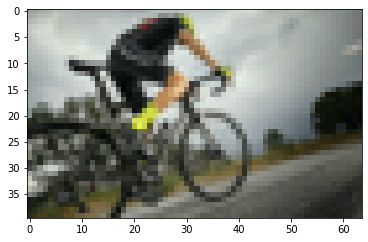

In [5]:
#Show a random imagen inside all_imgs
IMG_SIZE=64
num=random.randint(0,len(all_imgs)-1)

img = Image.open(all_imgs[num]['path']) 
img.thumbnail((IMG_SIZE, IMG_SIZE))
plt.figure()
plt.imshow(img)
print(all_imgs[num]['cath'])

In [6]:
#Create Dataset
def create_dataset(dataset, train_size,data_augmentation=False):
    #Image transformations
    preprocess = transforms.Compose ([
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]
                                )
    ])

    #Image tranformation if Data Augmentation = True
    data_augmentation_preprocess = transforms.Compose ([
                                    transforms.RandomHorizontalFlip(p=1),
    ])

    # %train_test = 1  - %train_size  
    train_size = train_size
    train_num = int(len(dataset)*train_size)
    train = dataset[:train_num]
    test = dataset[train_num:]
    # print(f'len_train = {len(train)}, len_test = {len(test)}')

    ##create train dataset##
    train_dataset=[]
    for image in train:
        #Call image
        img = Image.open(image['path']).convert('RGB')
        #transform image
        img_t = preprocess(img)
        #Flat image tensor
        batch = torch.unsqueeze(img_t, 0)
        
        #Transform moto_cathegory to a int between 0-9
        temp=None
        for i,cathegory in enumerate(motos_cathegory):
            if image[cathegory] == 1:
                temp=i
                break
        #Append tuple of image in tensor form and moto cathegory
        train_dataset.append((batch[0],temp))

        #Data Augmentation
        if data_augmentation==True:
            img_t2 = data_augmentation_preprocess(batch[0])
            batch2 = torch.unsqueeze(img_t2, 0)
            train_dataset.append((batch2[0], temp))

    ##create test dataset##
    test_dataset=[]
    for image in test:
        img = Image.open(image['path']).convert('RGB')
        img_t = preprocess(img)
        batch = torch.unsqueeze(img_t, 0)

        temp=None
        for i,cathegory in enumerate(motos_cathegory):
            if image[cathegory] == 1:
                temp=i
                break

        test_dataset.append((batch[0],temp))

    random.shuffle(train_dataset)
    print(f'train_dataset: {len(train_dataset)}, test_dataset: {len(test_dataset)}')
    return train_dataset, test_dataset

In [8]:
#Create train and test dataset
train_dataset, test_dataset = create_dataset(all_imgs, train_size=0.9, data_augmentation=True)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train_dataset: 1990, test_dataset: 111


##Net

In [9]:
#Create Net
class Net(nn.Module):
    def __init__(self, num_channels):
        super(Net,self).__init__()

        self.num_channels = num_channels
        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.num_channels)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.num_channels*2)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.num_channels*4)

        #full conected
        self.fc1 =  nn.Linear(self.num_channels*4*4*4*4, self.num_channels*4)
        self.fcbn1 =  nn.BatchNorm1d(self.num_channels*4)
        self.fc2 =  nn.Linear(self.num_channels*4, 10)

    def forward(self, x):
            #starts 3x64x64
            x = self.bn1(self.conv1(x)) #num_channelsx64x64
            x = F.relu(F.max_pool2d(x, 2)) #num_channelsx32x32
            x = self.bn2(self.conv2(x)) #num_channels*2x32x32
            x = F.relu(F.max_pool2d(x, 2)) #num_channels*2x16x16
            x = self.bn3(self.conv3(x)) #num_channels*4x16x16
            x = F.relu(F.max_pool2d(x, 2)) #num_channels*4x8x8
            #flatten
            x = x.view(-1, self.num_channels*4*4*4*4)
            # fc
            x = self.fc1(x)
            x = self.fcbn1(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.8, training=True)
            x = self.fc2(x)

            #log_softmax
            x = F.log_softmax(x, dim=1)
            return x

In [10]:
#Initializate net
net = Net(64)

##Training

In [11]:
#Trainloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

In [12]:
def training(net, train_dataloader, epochs, learning_rate):
    #Optimizers
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    epochs = epochs
    print('Inizializating Training...')
    loss=None
    for epoch in range(epochs):  # loop over the dataset multiple times
        if epoch % 10 == 0:
            print(f'epoch = {epoch}')
        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()

            if (epoch+1) == epochs and i % len(train_dataloader) == 0:
                print(f'epoch: {epoch+1} -> loss:{running_loss}')

            running_loss = 0.0

    print('Finished Training')
    return net


In [13]:
trained_net = training(net, train_dataloader, 10, 0.01)

Inizializating Training...
epoch = 0
epoch: 10 -> loss:1.3704795837402344
Finished Training


##Accuracy

In [16]:
#Accuracy
def accuracy(net, test_dataset):
    #Test dataloader
    test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                                batch_size=8,
                                                shuffle=False, 
                                                num_workers=2)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

In [17]:
accuracy(trained_net, test_dataset)

Accuracy of the network on the test images: 38 %


### Accuracy by cath

In [20]:
# Accurracy by cathegory
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                                batch_size=8,
                                                shuffle=False, 
                                                num_workers=2)

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    if class_total[i]==0:
        print(f'Accuracy of {motos_cathegory[i]} : 0%')
    else:
        print('Accuracy of %5s : %2d %%' % (
            motos_cathegory[i], 100 * class_correct[i] / class_total[i]))

Accuracy of off_road : 60 %
Accuracy of naked :  0 %
Accuracy of scooter : 50 %
Accuracy of scrambler : 25 %
Accuracy of cafe_racer :  0 %
Accuracy of cruiser :  0 %
Accuracy of sport : 33 %
Accuracy of touring : 40 %
Accuracy of  bike : 50 %
Accuracy of  quad : 50 %


##Find best hyperparameters

In [25]:
def find_best_params(dataset, hyperparams, data_augmentation=False):
    
    #Print params
    print('-'*30)
    for param in hyperparams:
        print(f'{param}: {hyperparams[param]}')
    print('-'*30)

    print(f"Creating dataset with a training size of: {hyperparams['train_size']}...")
    train_dataset, test_dataset = create_dataset(dataset, hyperparams['train_size'], data_augmentation=False)

    #Trainloader
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True, num_workers=2)

    print('Calling net...')
    net=None
    net = Net(64)

    #Training net
    trained_net = training(net, train_dataloader, hyperparams['epochs'], hyperparams['lr'])
    
    print('Calculating accuracy...')
    accuracy(trained_net, test_dataset)
    return trained_net



In [26]:
hyperparams={
    'lr': 0.025,
    'epochs': 1,
    'batch_size' : 32,
    'train_size' : 0.9
}

net = find_best_params(all_imgs, hyperparams, True)

------------------------------
lr: 0.025
epochs: 1
batch_size: 32
train_size: 0.9
------------------------------
Creating dataset with a training size of: 0.9...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train_dataset: 995, test_dataset: 111
Calling net...
Inizializating Training...
epoch = 0
epoch: 1 -> loss:2.770188808441162
Finished Training
Calculatig accuracy...
Accuracy of the network on the test images: 17 %


##Testing

In [27]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [28]:
def test_net_by_batch(dataloader, net, num_imgs=4):
    temp=[]
    for i in range(num_imgs):
        #choose a random image from test_dataset
        num=random.randint(0,len(test_dataset)-1)
        temp.append(test_dataset[num])

    batch_test_dataloader = torch.utils.data.DataLoader(temp, batch_size=num_imgs,
                                        shuffle=False, num_workers=2)
    dataiter = iter(batch_test_dataloader)
    images, labels = dataiter.next()
    # print images
    imshow(torchvision.utils.make_grid(images))

    #Call prediciton
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    for i in range(num_imgs):
        print(f'Real tag: {motos_cathegory[labels[i]]} | Prediction: {motos_cathegory[predicted[i]]}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


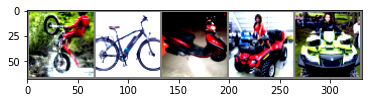

Real tag: off_road | Prediction: quad
Real tag: bike | Prediction: cafe_racer
Real tag: scooter | Prediction: scrambler
Real tag: quad | Prediction: sport
Real tag: quad | Prediction: off_road


In [29]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                                batch_size=8,
                                                shuffle=False, 
                                                num_workers=2)
#Call testing
test_net_by_batch(test_dataloader, net, 5)

##Save model

In [ ]:
#Save trained model
PATH = '/path/model.pth'
torch.save(net.state_dict(), PATH)